# `AA Workshop 7` - Decision Trees

In this workshop we take a deep-dive on tree-based methods, commonly used in a myriad of classification and regression problems.

We will cover the following: 
1. Decision Trees for classification (breast cancer example)
1. Decision Trees for regression (peak electrical power example)

**Decision Trees (DTs)** are a non-parametric supervised learning method used for *classification* `<tree_classification>` and *regression* `<tree_regression>`. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data
features.

Some advantages of decision trees are:

- Simple to understand and to interpret. Trees can be visualised.

- Requires little data preparation. Other techniques often require data normalisation, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.

- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.

- Able to handle both numerical and categorical data. Other techniques are usually specialised in analysing datasets that have only one type of variable. 

- Able to handle multi-output problems.

- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.

- Possible to validate a model using statistical tests. That makes it possible to account for the reliability of the model.

- Performs well even if its assumptions are somewhat violated by the true model from which the data were generated.


The disadvantages of decision trees include:

- Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.

- The problem of learning an optimal decision tree is known to be NP-complete under several aspects of optimality and even for simple concepts. Consequently, practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree.  This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


%matplotlib inline

Class of `DecisionTreeClassifier` is a class capable of performing multi-class classification on a dataset.

As with other classifiers, `DecisionTreeClassifier` takes as input two arrays: an array X, sparse or dense, of size ``[n_samples, n_features]``  holding the training samples, and an array Y of integer values, size ``[n_samples]``, holding the class labels for the training samples.

# Decision Trees for classification: classifying breast cancer cells

In [2]:
cancer_df = pd.read_csv("breast_cancer.csv", index_col="id")

In [3]:
cancer_df.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


To abstract from the relatively high-dimensionality of the breats cancer datset let us confine our analysis to a tow-dimensional feature vector consiting of `area_mean` and `concave points_mean` for now.

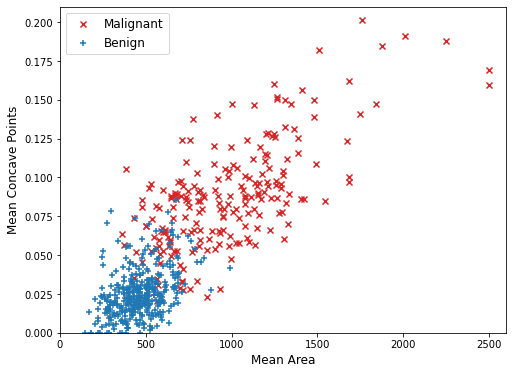

In [4]:
def plot_cells():
    plt.figure(figsize=(8,6))
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area",fontsize=12)
    plt.ylabel("Mean Concave Points",fontsize=12)
    plt.legend(['Malignant','Benign'],fontsize=12)
    
plot_cells()

We define X and Y vectors correspondingly:

In [5]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values
# vector of our output as our diagn.

Y  = np.where(Y=="M", int(1), Y) 
Y  = np.where(Y=="B", int(0), Y) 
Y = Y.astype('int')

Note that we do not need to normalize, as Decision Trees do not work based on distances across features!

We then specify and fit a simple `DecisionTreeClassifier`, which is available via `sklearn`

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree_classifier = DecisionTreeClassifier(max_depth=4,
                                  criterion='gini') 
# we set gini as our impurity measure and "entropy" is used for the information gain
tree_classifier.fit(X, Y)

DecisionTreeClassifier(max_depth=4)

The decision estimator has an attribute called `tree_`  which stores the entire tree structure and allows access to low level attributes. The binary `tree_` attribute is represented as a number of parallel arrays. The i-th element of each array holds information about the node `i`. Node 0 is the tree's root.

In [17]:
structure = tree_classifier.tree_

# structure of the fitted classi.: .tree_
# store our tree

Among those arrays, we have:

   - left_child, id of the left child of the node
   - right_child, id of the right child of the node
   - feature, feature used for splitting the node
   - threshold, threshold value at the node
   - impurity, the impurity (i.e., the value of the splitting criterion) at the node
   - etc.

In [8]:
# assign various tree attributes
n_leafs = structure.n_leaves
n_nodes = structure.node_count
children_left = structure.children_left
children_right = structure.children_right
feature = structure.feature
threshold = structure.threshold
impurity = structure.impurity

In [9]:
print("Num nodes: \t",n_nodes)
print("Num leaves: \t",n_leafs)

Num nodes: 	 29
Num leaves: 	 15


In [10]:
print("left children per node: ", children_left)
print("right children per node: ", children_right)
print("Decision feature at node: ", feature)
print("Threshold of feature at node", threshold)
print("Impurity at node: ", impurity)

left children per node:  [ 1  2  3  4 -1 -1  7 -1 -1 10 11 -1 -1 14 -1 -1 17 18 19 -1 -1 -1 23 24
 -1 -1 27 -1 -1]
right children per node:  [16  9  6  5 -1 -1  8 -1 -1 13 12 -1 -1 15 -1 -1 22 21 20 -1 -1 -1 26 25
 -1 -1 28 -1 -1]
Decision feature at node:  [ 1  0  1  0 -2 -2  1 -2 -2  0  1 -2 -2  0 -2 -2  0  1  0 -2 -2 -2  1  1
 -2 -2  0 -2 -2]
Threshold of feature at node [ 5.14199995e-02  6.96250000e+02  4.47000004e-02  5.62549988e+02
 -2.00000000e+00 -2.00000000e+00  4.49299999e-02 -2.00000000e+00
 -2.00000000e+00  7.98899994e+02  2.69799996e-02 -2.00000000e+00
 -2.00000000e+00  8.47849976e+02 -2.00000000e+00 -2.00000000e+00
  6.56500000e+02  7.94100016e-02  3.49949997e+02 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00  6.23250008e-02  6.11600000e-02
 -2.00000000e+00 -2.00000000e+00  6.76299988e+02 -2.00000000e+00
 -2.00000000e+00]
Impurity at node:  [0.46753006 0.10804509 0.05290204 0.03124213 0.01532476 0.10140306
 0.375      0.         0.32       0.47530864 0.32       0.
 0.19

every minus value means it is a leaf

`clr.tree_.feature` returns the nodes/leaves in a sequential order as a Depth-First Search algorithm. First, it starts with the the root node and then follows the left children until it reaches a leaf (coded with -2), when it reaches the a leaf it climbs the tree from leaf to leaf until it reaches a node. Once it reaches a node, it descends again in the hierarchy until it reaches a leaf node.

Next let's retrieve the decision path of a selected sample. 

The `decision_path` method allows to retrieve the node indicator functions. A non zero element of indicator matrix at the position (i, j) indicates that the sample i goes through the node j.

In [23]:
node_indicator = tree_classifier.decision_path(X)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = tree_classifier.apply(X)

# Now, it's possible to get the tests that were used to predict a sample

sample_id = np.random.randint(0,len(X))

# index node, i.e. which nodes does the sample pass
node_index = node_indicator.indices[node_indicator.indptr[sample_id]: #indptr maps the elements of data and indices to the rows of the sparse matrix
                                    node_indicator.indptr[sample_id + 1]]  #indptr maps the elements of data and indices to the rows of the sparse matrix

In [24]:
# sample with sample_id passes through the following nodes 
# node 0 is the root
# final node is the leave
print(sample_id)
node_index

422


array([0, 1, 2, 6, 8], dtype=int32)

In [13]:
print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    
    # skip leave node
    if leave_id[sample_id] == node_id:
        continue
    
    # 
    if (X[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

Rules used to predict sample 181: 
decision id node 0 : (X[181, 1] (= 0.1496) > 0.051419999450445175)
decision id node 16 : (X[181, 0] (= 1311.0) > 656.5)
decision id node 22 : (X[181, 1] (= 0.1496) > 0.06232500076293945)
decision id node 26 : (X[181, 0] (= 1311.0) > 676.2999877929688)


(= 0.1496) > 0.051419999450445175)
value and trashhold

### ?


### Plot decision tree

Arguably this is a little abstract and not too intuitive. Therefore, we will visualize the underlying tree and try to relate it back to the tree structure above.

We will visualize the decision tree using `graphviz`. If you haven't done so already please go ahead and install `graphviz` by sequentially executing the two following commands via the terminal:
- `conda install -c anaconda graphviz `
- ` conda install -c conda-forge python-graphviz`

In [19]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

def plot_class_tree_sklearn(tree_depth):

    model = DecisionTreeClassifier(max_depth=tree_depth,
                                  criterion='gini') # we set gini as our impurity measure
    model.fit(X, Y)
    
    dot_data = export_graphviz(model,
                               feature_names=['area_mean','concave points_mean'],
                              class_names = ["Begning","Malignant"],out_file=None)  
    
    graph = graphviz.Source(dot_data) 
    
    return graph
#    return graph.render("clf_tree_depth_"+str(tree_depth))

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
plot_class_tree_sklearn(6)

In the decision tree each node is represented by a box. For each node the following information is provided:
- decision feature and threshold
- impurity
- number of samples
- number of samples per class
- class (i.e., majority vote)
- Value: The value line in each box is telling you how many samples at that node fall into each category, in order. That's why, in each box, the numbers in value add up to the number shown in sample. For instance, in the far left leaf, 193+47 = 240 (in a tree with the depth of 6) which is the number of sample in the above node. Looking at the far left leaf, we can see that at this leaf, there were 193 data points in class 1 and 0 data points in class 2.


We can, thus, easily relate this back to the tree attributes we computed above. A selection is below:

In [20]:
print("Num nodes: \t",n_nodes)
print("Num leafs: \t",n_leafs)
print("Feature at node", feature) # -2 indicates no feature/threshold, i.e. a leaf
print("Threshold of feature at node", threshold)
print("Impurity at node: ", impurity)

Num nodes: 	 29
Num leafs: 	 15
Feature at node [ 1  0  1  0 -2 -2  1 -2 -2  0  1 -2 -2  0 -2 -2  0  1  0 -2 -2 -2  1  1
 -2 -2  0 -2 -2]
Threshold of feature at node [ 5.14199995e-02  6.96250000e+02  4.47000004e-02  5.62549988e+02
 -2.00000000e+00 -2.00000000e+00  4.49299999e-02 -2.00000000e+00
 -2.00000000e+00  7.98899994e+02  2.69799996e-02 -2.00000000e+00
 -2.00000000e+00  8.47849976e+02 -2.00000000e+00 -2.00000000e+00
  6.56500000e+02  7.94100016e-02  3.49949997e+02 -2.00000000e+00
 -2.00000000e+00 -2.00000000e+00  6.23250008e-02  6.11600000e-02
 -2.00000000e+00 -2.00000000e+00  6.76299988e+02 -2.00000000e+00
 -2.00000000e+00]
Impurity at node:  [0.46753006 0.10804509 0.05290204 0.03124213 0.01532476 0.10140306
 0.375      0.         0.32       0.47530864 0.32       0.
 0.19753086 0.46875    0.         0.48       0.22214876 0.48661157
 0.49975309 0.         0.49732302 0.         0.05876951 0.30839002
 0.18836565 0.         0.01379244 0.32       0.        ]


### Plot decision surfaces

As we have seen in the lecture another intuitive representation of decision trees is the use of decsion surfaces. These can be related back directly to the decision tree. For ease of use a plotting routine has been prepared that combines fitting and plotting into a single routine and allows for easy adjustment of tree-depth.

In [21]:
def plot_class_surface(tree_depth):
    
    # specify and fit decision tree classifier
    #from sklearn.tree import DecisionTreeClassifier, export_graphviz 
    # we also call the garphviz module for later visualization
    model = DecisionTreeClassifier(max_depth=tree_depth,
                                  criterion='gini') # we set entropy as our impurity measure
    model.fit(X, Y)
    
    # get tree attributes
    
    attributes = model.tree_
    
    # define range per feature
    x_range = [0,2600] # i.e. mean area
    y_range = [0, 0.21] # i.e mean conc. points
    plt.figure(figsize=(8,6))
    
    
    # plot classifcation regions
    grid=1000
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))


    zz = model.predict(np.c_[xx.ravel(), yy.ravel()])
    zz = zz.reshape(xx.shape)
    cs = plt.contourf(xx, yy,zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')
    
    # plot datapoints
    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area",fontsize=16)
    plt.ylabel("Mean Concave Points",fontsize=16)
    plt.legend([s1,s2],['Malignant','Benign'],fontsize=12)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    
    plt.show()
    
    #plt.savefig("Breast_Cancer_Decision_Surface_{}depth.pdf".format(tree_depth))

- visualize scatter plot
- create areas (blue/red)
- graphgröße
- ..

number of nodes:  103
number of leafs:  52


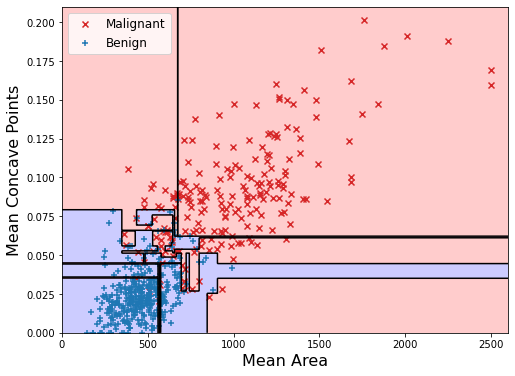

In [30]:
plot_class_surface(15)

# übergeben der Anzahl der Splits

### Controlling overfitting in Decision Trees

**Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.**

This can easyily be seen by increasin tree depth to unreasonable values:

In [ ]:
plot_class_surface(15)

### Optimizing tree predictive performance

- **max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).
- **min_samples_leaf**: By specifying a minimum number of samples per leaf (>>1); overfitting can be controlled for
- **ccp_alpha**: Cost Complexity (CCP) alpha paramter determines the size of the penalty


In this example we will look at the **cost complexity** as an effective measure in avoiding overfitting. The cost complexity of a tree (CCP(T)) is defined as 

\begin{equation}
CCP(T) = ERR(Z) + \alpha L(T)
\end{equation}

To get an idea of what values of $\alpha$ could be appropriate, `scikit-learn` provides `DecisionTreeClassifier.cost_complexity_pruning_path` that returns the effective alphas (i.e. those that will achieve the next step in complexity reduction) and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

# fit decision tree (without limit on max_depth, i.e. tree will grow fully if alpha is set to 0)
tree_classifier = DecisionTreeClassifier(random_state=0, 
                                         criterion="gini")

# compute cost_complexity_pruning_path
# function: cost_complexity_pruning_path

path = tree_classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# vector of relevant alphas and impurity of that

vector of relevant alphas and impurity of that

### ?

In [33]:
path

{'ccp_alphas': array([0.        , 0.00176056, 0.00195618, 0.00205399, 0.00223564,
        0.00229283, 0.00230624, 0.00234045, 0.00289975, 0.00304859,
        0.0031951 , 0.00358596, 0.00383565, 0.00457548, 0.00485534,
        0.00652311, 0.01323716, 0.01731205, 0.32729844]),
 'impurities': array([0.        , 0.00352113, 0.00938967, 0.01349765, 0.02020456,
        0.02479021, 0.02940268, 0.03408358, 0.04568259, 0.05177978,
        0.05497487, 0.06573274, 0.08491099, 0.09863742, 0.10349276,
        0.11001587, 0.12325303, 0.14056508, 0.46786352])}

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

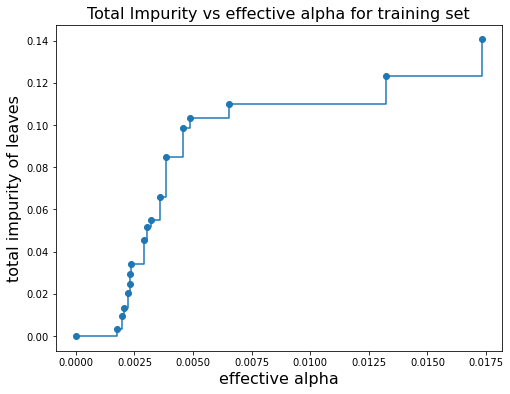

In [37]:
#plot cost_complexity_pruning_path

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")  # we remove the last alpha as this corresponds to a tree with only the root node
ax.set_xlabel("effective alpha",fontsize=16)
ax.set_ylabel("total impurity of leaves",fontsize=16)
ax.set_title("Total Impurity vs effective alpha for training set",fontsize=16)

#plt.savefig("Determining_Alpha.pdf")

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [35]:
trees = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      trees[1].tree_.node_count, ccp_alphas[1]))

Number of nodes in the last tree is: 75 with ccp_alpha: 0.0017605633802816902


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

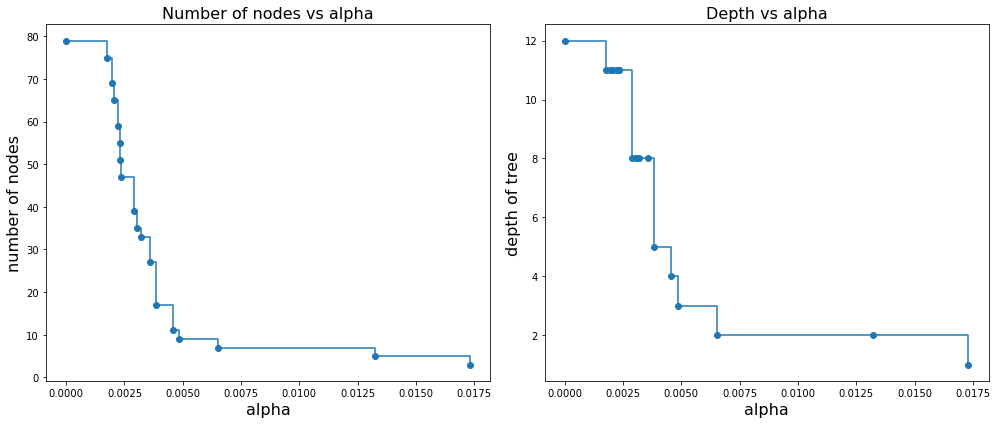

In [38]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha",fontsize=16)
ax[0].set_ylabel("number of nodes",fontsize=16)
ax[0].set_title("Number of nodes vs alpha",fontsize=16)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha",fontsize=16)
ax[1].set_ylabel("depth of tree",fontsize=16)
ax[1].set_title("Depth vs alpha",fontsize=16)
fig.tight_layout()

#plt.savefig("Pruning_effect.pdf")

In [ ]:
len(ccp_alphas)

**Exercise**: Implement a grid search over the identified effective alphas to determine where predictive performance is maximized. Report the validation error for this setting.

In [39]:
### YOUR CODE HERE

scores_train = []
scores_val = []

# run loop
for ccp_alpha in ccp_alphas:
    
    model = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)    
    
    from sklearn.metrics import accuracy_score
    accuracy_train = accuracy_score(y_train, model.predict(X_train)) #predict. outcome of train set
    accuracy_val = accuracy_score(y_test, model.predict(X_test))
    scores_val.append(accuracy_val)
    scores_train.append(accuracy_train)
    
# collect results in DF
df = pd.DataFrame(columns=["alpha","train_score","test_score"])
df["alpha"]=ccp_alphas
df["train_score"] = scores_train
df["test_score"] = scores_val

# show top five alphas
df.sort_values("test_score",ascending=False).head(5)

,alpha,train_score,test_score
11,0.003586,0.957746,0.930070
9,0.003049,0.964789,0.923077
6,0.002306,0.981221,0.923077
7,0.002340,0.978873,0.923077
10,0.003195,0.962441,0.923077


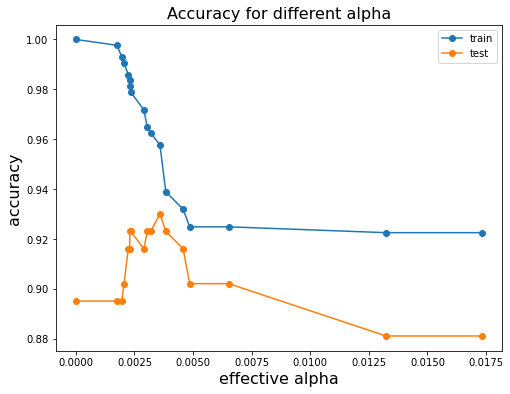

In [40]:
plt.subplots(figsize=(8,6))
plt.plot(df["alpha"],df["train_score"], marker='o')
plt.plot(df["alpha"],df["test_score"], marker='o')
plt.legend(["train","test"])
plt.xlabel("effective alpha",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.title("Accuracy for different alpha",fontsize=16)
#plt.savefig("alpha_tuning.pdf")
plt.show()

# Decision Trees for regression: predicting peak electrical power

We continue with our electric power example from last week which we retieved from PJM from the following link [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition)). The files we are loading are the raw files we downloaded from this source. The final input data for our code is `Pittsburgh_load_data.csv`.

In [41]:
df = pd.read_csv("Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df["Month"] = df["Date"].apply(lambda x: x.month)
df.head(2)

,Date,AVG,MAX,MIN,Total,High_temp,Avg_temp,Month
0,2013-01-01,1.598524,1.859947,0.001599,38.368031,0.0,-1.68,1
1,2013-01-02,1.809347,2.054215,0.001809,43.428194,-3.9,-6.58,1


In [44]:
Xp = df["High_temp"].values
Yp = df["MAX"].values

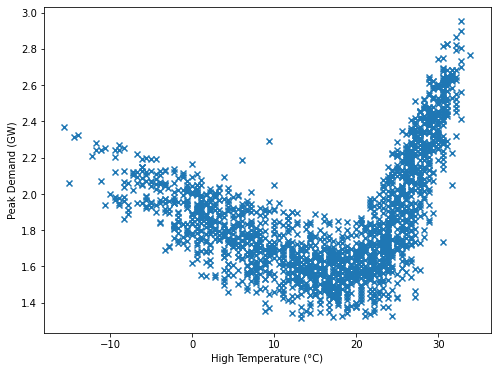

In [45]:
plt.figure(figsize = (8,6))
plt.scatter(Xp, Yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

We will unse the `DecisionTreeRegressor` class in `scikitlearn`to fit and plot a decision tree regressor.

In [46]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def plot_tree_regression_line(tree_depth):

    # Fit regression model (to full data)
    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="mse") # Other options: "friedman_mse", "mae"
    Tree_reg.fit(Xp.reshape((-1,1)), Yp)
    Y_pred = Tree_reg.predict(Xp.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    # plot
    plt.figure(figsize = (8,6))
    plt.scatter(Xp, Yp, marker="x")
    plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
    plt.xlabel("High Temperature (°C)", fontsize=16)
    plt.ylabel("Peak Demand (GW)", fontsize=16)
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(Yp, Y_pred))
    
    
    #plt.savefig("Peak_Power_Regression_Lines_{}depth.pdf".format(tree_depth))

number of nodes:  127
number of leafs:  64
R^2:  0.7605609145871184


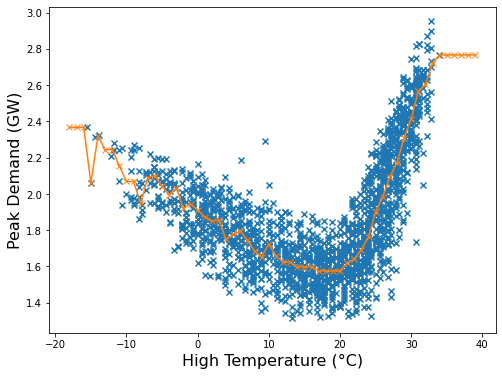

In [47]:
plot_tree_regression_line(8)

In [48]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

def plot_regression_tree_sklearn(tree_depth):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(Xp.reshape((-1,1)), Yp) 
    
    dot_data = export_graphviz(model,
                              feature_names=["High_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

ModuleNotFoundError: No module named 'graphviz'

In [49]:
plot_regression_tree_sklearn(6)

NameError: name 'plot_regression_tree_sklearn' is not defined

---